# CTR prediction with wide and deep model

In this notebook, I show how to build a wide and deep model with 3 hidden layers in the deep part of the model. The model is trained 15 epochs using the Avazu CTR prediction dataset. The training yields a log loss of 0.3958 over the test dataset.

### Brief introduction of the dataset
The dataset I used in this project is the famous [Avazu CTR dataset](https://www.kaggle.com/c/avazu-ctr-prediction) from Kaggle

From the overview on the Kaggle page, the data fields in this dataset are:
- id: ad identifier
- click: 0/1 for non-click/click
- hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
- C1 -- anonymized categorical variable
- banner_pos
- site_id
- site_domain
- site_category
- app_id
- app_domain
- app_category
- device_id
- device_ip
- device_model
- device_type
- device_conn_type
- C14-C21 -- anonymized categorical variables

All features are categorical. This is a binary classification problem where our model need to predict `click` that can be either 0 (no click) or 1 (click).

This project can be separated into 2 steps as outlined below.

### Step 1 - Feature engineering with Spark on K8s

In this initial step, I deployed a [spark job](https://github.com/yinanli617/ctr-prediction/blob/master/docker/pyspark-ctr.py) on K8s using the [spark-on-k8s-operator](https://github.com/GoogleCloudPlatform/spark-on-k8s-operator) to -

- Load the raw data;
- Generate *wide features* and *deep features*, which will be fed to the model in the next step;
- Split the dataset into training set and test set (7:3);

#### About the features used

1. Wide features:
   - All raw features with a number of unique values below 100 are used;
   - The following cross-product features are constructed:
     - `hr` and `device_type`;
     - `device_type` and `app_category`;
     - `device_type` and `site_category`;
     - `banner_pos` and `device_type`;
   - The "single" features and the cross-product features are one-hot encoded to generate the wide features (dimension: 475).

2. Deep features:
   - Embeddings of the following features are generated and fed to the deep part of the model:
     - `device_model` (embedding_dim: 256);
     - `app_id` (embedding_dim: 256);
     - `site_id` (embedding_dim: 256);
     - `site_domain` (embedding_dim: 256);
     - `app_domain` (embedding_dim: 128);

### Step 2 - Training wide and deep model with PyTorch predict CTR

***Note: This notebook shows how to train the model on a local laptop equipped with an Nvidia RTX2070 super max-q GPU. A slightly modified version of the codes can be found in `/pytorch_docker/wide_deep_k8s.py` which is used to deploy the pytorch job on Kubernetes. Training on K8s was done on an Nvidia Tesla K80 GPU.***

Details about the model architecture:
- The deep part of the model contains 3 hidden layers with `hidden_size = [512, 256, 128]`;
- Relu is used as activation function in the deep part;
- The original [paper](https://arxiv.org/abs/1606.07792) used L1 regularization for the wide part. Here, Adam optimizer is used for both wide and deep parts. However, a dropout layer with `dropout_p=0.7` is added to the wide part before merging with the deep part. The Dropout layer is meant for regularization.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import IterableDataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [3]:
# During the first step where I extract wanted features in a spark job,
# the features that I would like to feed to the deep part of the model
# were named as <feature_name>SEP<num_of_unique_values>SEP<embedding_dim>


WIDE_DIM = 453
COLUMNS = ['label',
           'device_modelSEP8251SEP256',
           'app_idSEP8552SEP256',
           'site_idSEP4737SEP256',
           'site_domainSEP7745SEP256',
           'app_domainSEP559SEP128',
          ]
COLUMNS = ['wide_feature_' + str(i) for i in range(WIDE_DIM)] + COLUMNS
EMBEDDING_INPUTS = COLUMNS[-5:]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 6
EPOCHS = 15

print(DEVICE)
print(torch.cuda.get_device_name(DEVICE))

cuda
GeForce RTX 2070 Super with Max-Q Design


## Define the Wide and Deep Model Class

In [3]:
class WideAndDeep(nn.Module):
    def __init__(self, wide_dim, embedding_inputs, hidden_layers, dropout_p=0.5):
        super().__init__()
        self.wide_dim = wide_dim
        self.embedding_inputs = embedding_inputs
        self.deep_feature_dim = 0
        self.hidden_layers = hidden_layers
        
        # For each deep feature, create an embedding layer to convert them to embeddings
        for embedding_input in self.embedding_inputs:
            col_name, vocab_size, embed_dim = embedding_input.split('SEP')
            setattr(self, col_name+'_emb_layer', nn.Embedding(int(vocab_size), int(embed_dim)))
            self.deep_feature_dim += int(embed_dim)
        
        # A series of hidden layers that take the embeddings as input
        self.linear_layer_1 = nn.Linear(self.deep_feature_dim, self.hidden_layers[0])
        self.bn_1 = nn.BatchNorm1d(self.hidden_layers[0])
        for i, hidden_layer in enumerate(self.hidden_layers[1:]):
            setattr(self, f'linear_layer_{i+2}', nn.Linear(self.hidden_layers[i], hidden_layer))
        
        self.dropout = nn.Dropout(p=dropout_p)
        
        # Final dense layer that combine the wide features and the deep features and generate output
        self.fc = nn.Linear(self.wide_dim+self.hidden_layers[-1], 1)
        
    
    def forward(self, X_w, X_d):
        embeddings = [getattr(self, col_name+'_emb_layer')(X_d[:, i].long())
                      for i, embedding_input in enumerate(self.embedding_inputs)
                      for col_name in embedding_input.split('SEP')
                      if not col_name.isdigit()
                     ]
        
        deep_out = torch.cat(embeddings, dim=-1) # concatenate the embeddings of all deep features
        
        for i, _ in enumerate(self.hidden_layers):
            deep_out = F.relu(getattr(self, f'linear_layer_{i+1}')(deep_out))
        
        X_w = self.dropout(X_w) # Apply a dropout layer to the wide features for regularization purposes
        fc_input = torch.cat([X_w, deep_out], dim=-1) # concatenate the wide and processed deep features
        out = self.fc(fc_input)
        
        return out

## Define the Dataset

Since the size of the dataset is too big, I use the `pandas` package to read only a chunk of the dataset at each step which can fit in memory.

In [4]:
# Split the dataset into <num_workers> parts, so that each worker get a unique copy of a part of the dataset
# https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset

class CtrDataset(IterableDataset):
    def __init__(self, chunksize=10000, train=True):
        super().__init__()
        self.train = train
        if self.train:
            self.num_lines = 28303473 # wc -l ./train_full.csv
            self.path = './train_full.csv'
        else:
            self.num_lines = 12125494 # wc -l ./validation_full.csv
            self.path = './validation_full.csv'
        self.chunksize = chunksize
        self.start = 0
        self.end = self.num_lines + self.start - 1
    
    def process_data(self, data):
        for i, chunk in enumerate(data):
            if self.start + i*chunk.shape[0] >= self.end:
                break
            else:
                chunk.columns = COLUMNS
                
                # Don't repeat at the end of each partition
                size = min(self.chunksize, self.end - (self.start + i*chunk.shape[0]))
                
                X_w = chunk.iloc[:size, :WIDE_DIM].values.astype(np.float32).squeeze()
                X_d = chunk.iloc[:size][EMBEDDING_INPUTS].values.astype(np.float32).squeeze()
                label = chunk.iloc[:size]['label'].values.astype(np.float32).squeeze()
                yield X_w, X_d, label
    
    def __iter__(self):
        self.df = pd.read_csv(self.path,
                             header=None,
                             chunksize=self.chunksize,
                             skiprows=self.start,
                            )
        return self.process_data(self.df)

def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset  # the dataset copy in this worker process
    overall_start = dataset.start
    overall_end = dataset.end
    # configure the dataset to only process the split workload
    per_worker = int(math.ceil((overall_end - overall_start) / float(worker_info.num_workers)))
    worker_id = worker_info.id
    dataset.start = overall_start + worker_id * per_worker
    dataset.end = min(dataset.start + per_worker, overall_end)

In [5]:
# A helper function to get the total number of batches

def get_total(dset, dl):
    temp = int(math.ceil((dset.end - dset.start) / float(dl.num_workers))) 
    total = int(math.ceil(temp / dset.chunksize)) * dl.num_workers
    
    return total

## Training function

In [6]:
def training(model, train_dl, scaler, optimizer, loss_fn, train_total):
    pbar = tqdm(train_dl, total=train_total)
    model.train()
    total_loss = 0
    n = 0
    for batch_i, (X_w, X_d, label) in enumerate(pbar):
        X_w = X_w.squeeze().to(DEVICE, non_blocking=True)
        X_d = X_d.squeeze().to(DEVICE, non_blocking=True)
        label = label.squeeze().unsqueeze(1).to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(X_w, X_d)
            loss = loss_fn(outputs, label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * label.shape[0]
        n += label.shape[0]

        running_loss = total_loss / n
        pbar.set_description(f'Training Loss: {running_loss}')
    
    return running_loss

## Validation function

In [7]:
def validation(model, val_dl, loss_fn, val_total):
    pbar = tqdm(val_dl, total=val_total)
    model.eval()
    total_loss = 0
    n = 0
    for batch_i, (X_w, X_d, label) in enumerate(pbar):
        X_w = X_w.squeeze().to(DEVICE, non_blocking=True)
        X_d = X_d.squeeze().to(DEVICE, non_blocking=True)
        label = label.squeeze().unsqueeze(1).to(DEVICE, non_blocking=True)
        
        with torch.no_grad() and torch.cuda.amp.autocast():
            outputs = model(X_w, X_d)
            loss = loss_fn(outputs, label)
            
        total_loss += loss.item() * label.shape[0]
        n += label.shape[0]

        running_loss = total_loss / n
        pbar.set_description(f'Validation Loss: {running_loss}')
    
    return running_loss

In [8]:
def main():
    model = WideAndDeep(wide_dim=WIDE_DIM, embedding_inputs=EMBEDDING_INPUTS, hidden_layers=[512, 256, 128],
                    dropout_p=0.7,
                   )
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=1e-3,
    #                              weight_decay=0.01,
                                )

    loss_fn = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler() # For mixed precision training

    lr_scheduler = StepLR(optimizer,
                          step_size=5,
                          gamma=0.1,
                          last_epoch=-1,
                          verbose=True,
                         )

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(1, EPOCHS+1):
        train_dset = CtrDataset(train=True, chunksize=2048)
        train_dl = DataLoader(train_dset,
                              batch_size=1,
                              num_workers=NUM_WORKERS,
                              worker_init_fn=worker_init_fn,
                             )
        val_dset = CtrDataset(train=False, chunksize=16384)
        val_dl = DataLoader(val_dset,
                            batch_size=1,
                            num_workers=NUM_WORKERS,
                            worker_init_fn=worker_init_fn,
                           )
        train_total = get_total(train_dset, train_dl)
        val_total = get_total(val_dset, val_dl)
        
        print(f'=============== Epoch {epoch} ===============')
        train_losses.append(training(model, train_dl, scaler, optimizer, loss_fn, train_total))
        val_losses.append(validation(model, val_dl, loss_fn, val_total))

        lr_scheduler.step()
        print('\n')
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1] 
            print('Best model saved.\n')
            torch.save(model.state_dict(), './saved_model.pt')
    
    return train_losses, val_losses

In [9]:
train_losses, val_losses = main()

Adjusting learning rate of group 0 to 1.0000e-03.
=============== Epoch 1 ===============


Validation Loss: 0.4020986238156853: 100%|████| 744/744 [02:56<00:00,  4.22it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


Best model saved.

=============== Epoch 2 ===============


Validation Loss: 0.40031580761289776: 100%|███| 744/744 [02:53<00:00,  4.29it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


Best model saved.

=============== Epoch 3 ===============


Validation Loss: 0.39906330775334636: 100%|███| 744/744 [02:53<00:00,  4.30it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


Best model saved.

=============== Epoch 4 ===============


Validation Loss: 0.39850517347543746: 100%|███| 744/744 [02:53<00:00,  4.28it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


Best model saved.

=============== Epoch 5 ===============


Validation Loss: 0.3999672847459322: 100%|████| 744/744 [02:55<00:00,  4.25it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


=============== Epoch 6 ===============


Validation Loss: 0.39624556673071915: 100%|███| 744/744 [02:53<00:00,  4.29it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


Best model saved.

=============== Epoch 7 ===============


Validation Loss: 0.39611545181397784: 100%|███| 744/744 [02:54<00:00,  4.25it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


Best model saved.

=============== Epoch 8 ===============


Validation Loss: 0.396045272539394: 100%|█████| 744/744 [02:58<00:00,  4.17it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


Best model saved.

=============== Epoch 9 ===============


Validation Loss: 0.39599160531555694: 100%|███| 744/744 [02:55<00:00,  4.25it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


Best model saved.

=============== Epoch 10 ===============


Validation Loss: 0.3959455820606816: 100%|████| 744/744 [02:54<00:00,  4.26it/s]


Adjusting learning rate of group 0 to 1.0000e-05.


Best model saved.

=============== Epoch 11 ===============


Validation Loss: 0.3958100941001549: 100%|████| 744/744 [02:53<00:00,  4.29it/s]


Adjusting learning rate of group 0 to 1.0000e-05.


Best model saved.

=============== Epoch 12 ===============


Validation Loss: 0.39578967798484943: 100%|███| 744/744 [02:56<00:00,  4.22it/s]


Adjusting learning rate of group 0 to 1.0000e-05.


Best model saved.

=============== Epoch 13 ===============


Validation Loss: 0.3957772384933947: 100%|████| 744/744 [02:57<00:00,  4.19it/s]


Adjusting learning rate of group 0 to 1.0000e-05.


Best model saved.

=============== Epoch 14 ===============


Validation Loss: 0.39577374951423927: 100%|███| 744/744 [03:07<00:00,  3.97it/s]


Adjusting learning rate of group 0 to 1.0000e-05.


Best model saved.

=============== Epoch 15 ===============


Validation Loss: 0.3957672762115228: 100%|████| 744/744 [02:59<00:00,  4.15it/s]


Adjusting learning rate of group 0 to 1.0000e-06.


Best model saved.



## Plot loss history

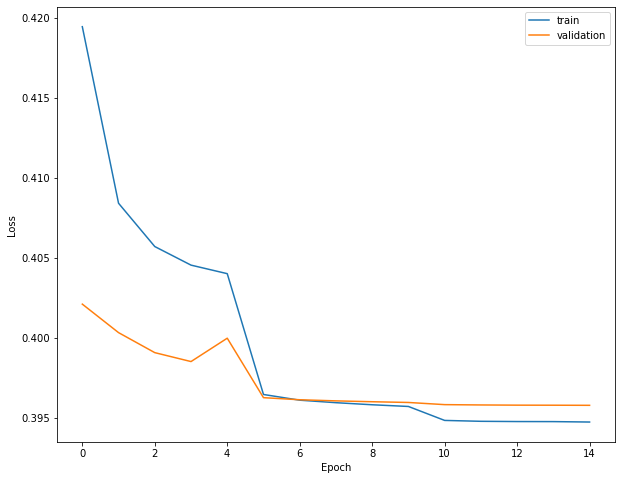

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()